## AMAL - TP3 : Implémentation de module, Gestion de données, Checkpointing et GPU

Quand j'ai commmencé le TP, le module datamaestro ne fonctionnait pas donc je vais chercher les données par une autre source (package mlxtend).

In [1]:
from matplotlib import pyplot as plt
import torch
import torchvision
from mlxtend.data import loadlocal_mnist
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from pathlib import Path
import time

In [2]:
torch.manual_seed(12)
torch.cuda.manual_seed(12)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
BATCH_SIZE = 32
EPS = 0.5
NB_EPOCH = 20
COMPRESSED_DIM = 40
ORIGINAL_DIM = 784
savepath = Path("model.plt")

In [5]:
train_images, train_labels = loadlocal_mnist(
        images_path='train-images.idx3-ubyte', 
        labels_path='train-labels.idx1-ubyte')

In [6]:
test_images, test_labels = loadlocal_mnist(
        images_path='t10k-images.idx3-ubyte', 
        labels_path='t10k-labels.idx1-ubyte')

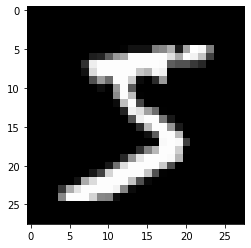

Label: 5


In [7]:
# un exemple d'image
plt.imshow(train_images[0].reshape((28, 28)), cmap='gray')
plt.show()
print('Label: %d' %train_labels[0])

In [8]:
class MonDataset(torch.utils.data.Dataset):
    
    def __init__(self, x, y):
        self.x = torch.from_numpy(x.astype(float) / 255).float().to(device)
        self.y = torch.from_numpy(y.astype(float) / 255).float().to(device)
    
    def __getitem__(self, index): 
        return self.x[index], self.y[index] 
    
    def __len__(self):
        return len(self.x)

In [9]:
dataset_train = MonDataset(train_images, train_labels)
dataset_test = MonDataset(test_images, test_labels)
data_loader = torch.utils.data.DataLoader(dataset_train, shuffle=True, batch_size=BATCH_SIZE) 
data_loader_test = torch.utils.data.DataLoader(dataset_test, shuffle=True, batch_size=1000) 

In [10]:
class Autoencodeur(torch.nn.Module):
    def __init__(self, shape, dim_compression, relu=False):
        super(Autoencodeur, self).__init__()
        
        self.lin1 = torch.nn.Linear(shape, dim_compression)
        self.lin2 = torch.nn.Linear(dim_compression, shape)
        self.lin2.weight = torch.nn.Parameter(self.lin1.weight.T)
        self.relu = relu
    
    def forward(self, train_x):
        if self.relu:
            encoder = torch.nn.functional.relu(self.lin1(train_x))
        else:
            encoder = self.lin1(train_x)
        decoder = torch.sigmoid(self.lin2(encoder))
        return decoder
                      

In [11]:
class State :
    def __init__ (self, model , optim ):
        self.model = model
        self.optim = optim
        self.epoch, self.iteration = 0, 0

In [12]:
if savepath.is_file():
    with savepath.open("rb") as fp :
        state = torch.load(fp)
else:
    autoencoder = Autoencodeur(ORIGINAL_DIM, COMPRESSED_DIM).to(device)
    optim = torch.optim.SGD(params=[autoencoder.lin1.weight, autoencoder.lin1.bias, autoencoder.lin2.bias],lr=EPS)
    state = State(autoencoder, optim)

loss = torch.nn.BCELoss()

Beginning epoch 1


/home/pmarion/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Autoencodeur. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Beginning epoch 2
Beginning epoch 3
Beginning epoch 4
Beginning epoch 5
Beginning epoch 6
Beginning epoch 7
Beginning epoch 8
Beginning epoch 9
Beginning epoch 10
Beginning epoch 11
Beginning epoch 12
Beginning epoch 13
Beginning epoch 14
Beginning epoch 15
Beginning epoch 16
Beginning epoch 17
Beginning epoch 18
Beginning epoch 19
Beginning epoch 20
Training time: 131.0399558544159


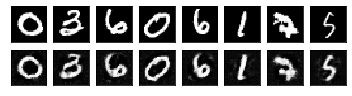

In [13]:
t = time.time()
writer = SummaryWriter()
for epoch in range(state.epoch, NB_EPOCH):
    print('Beginning epoch %d' %(epoch+1))
    
    for x,y in data_loader:
        state.optim.zero_grad()
        l = loss(state.model.forward(x), x) #Calcul du cout
        l.backward()
        state.optim.step()
        state.iteration += 1
        writer.add_scalar('Loss/train', l, state.iteration)

    with savepath.open("wb") as fp :
        state.epoch = epoch + 1
        torch.save(state, fp)
        
    with torch.no_grad():
        x_test,y_test = next(iter(data_loader_test))
        writer.add_scalar('Loss/test', loss(state.model.forward(x_test), x_test), state.iteration)
print('Training time: ' + str(time.time()-t))   
        
fig, axs = plt.subplots(nrows=2, ncols=8, subplot_kw={'xticks': [], 'yticks': []})
i = 0
image_original = np.zeros((8, 3, 28, 28))
image_transformed = np.zeros((8, 3, 28, 28))
for x,y in data_loader:
    xhat = state.model.forward(x)
    for j in range(3):
        image_original[i][j] = (x[0].cpu().detach().numpy().reshape((28, 28)) * 255).astype(int)
        image_transformed[i][j] = (xhat[0].cpu().detach().numpy().reshape((28, 28)) * 255).astype(int)
    axs[0, i].imshow(image_original[i][0], cmap='gray')
    axs[1, i].imshow(image_transformed[i][0], cmap='gray')
    i += 1
    if i == 8:
        break
plt.subplots_adjust(top = 0.4)
plt.show()
     
writer.add_images('original_images', image_original, state.iteration)
writer.add_images('transformed_images', image_transformed, state.iteration)
writer.close()